<a href="https://colab.research.google.com/github/cyrus-rule/Data-Science-/blob/main/Copy_of_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [ ]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [ ]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [ ]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

Text(0, 0.5, 'FG%')

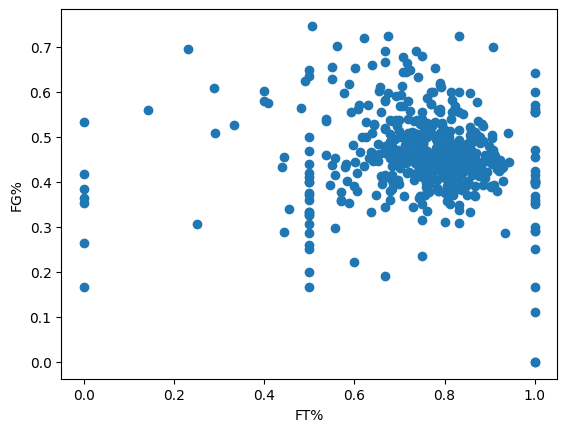

In [ ]:
plt.scatter(basketball['FT%'] , basketball['FG%'],)

plt.xlabel("FT%")
plt.ylabel("FG%")

Our data is a lot more spread now. Most significantly, we have strong vertical lines on 0, .5, and 1 free throw percentage. These trends weren't in the old data because these are players who have taken very few free throws, and we weeded those out earlier. Also, we have way lower field goal percentages than before, with substantially more players onder 30%.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

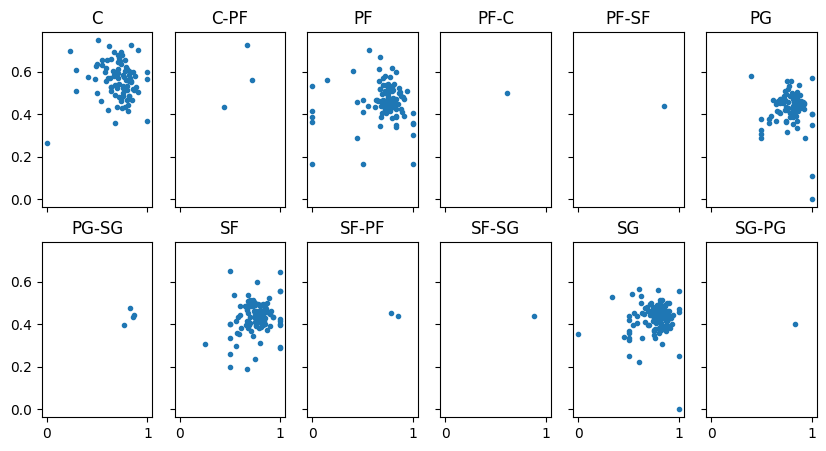

In [ ]:
pos_idx = basketball.Pos.cat.codes.values

pos_codes = basketball.Pos.cat.categories

bb_coords = {"pos": pos_codes}

_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")

The negative trends in C and PF seem a lot weaker now because there's so much extra noise.The other positions still don't seem to have much of a trend still. In general, there is a lot more spread, and we see a lot of data points that were outside of the range of the old data.

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

There doesn't really seem to be a discernable trend anymore. There's a lot of those  0%, 50%, 100% FT data points that make the trend foggier. Also, for players with very low field goal percentages or very low free throw percentages, all bets are off. If someone has a 0 percent free throw percentage, I can't really say anything about their field goal percentage. As a result, the idea of a linear regression doesn't make much sense because the model probably can't really discern any consistent relationship.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [ ]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [ ]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

Text(0, 0.5, 'weight')

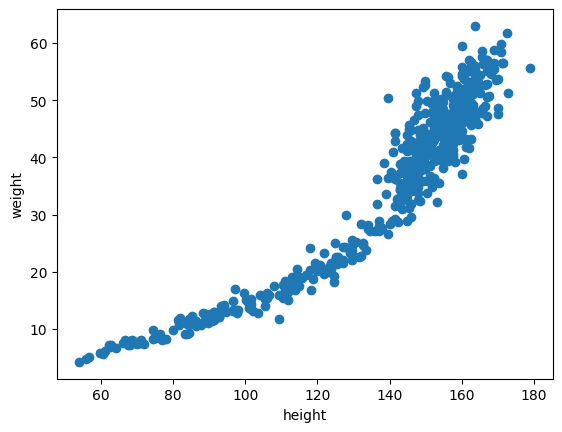

In [ ]:
plt.scatter(howell['height'] , howell['weight'],)

plt.xlabel("height")
plt.ylabel("weight")

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [ ]:
with pm.Model() as model_hw: #Just a straight up linear model, hw for height/weight

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * howell.height)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    #inference data object
    idata_hw = pm.sample()

Output()

Output()

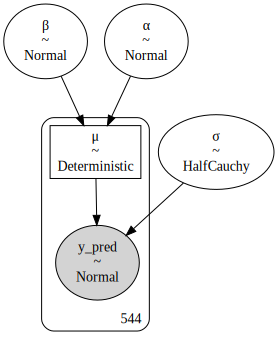

In [ ]:
pm.model_to_graphviz(model_hw)

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

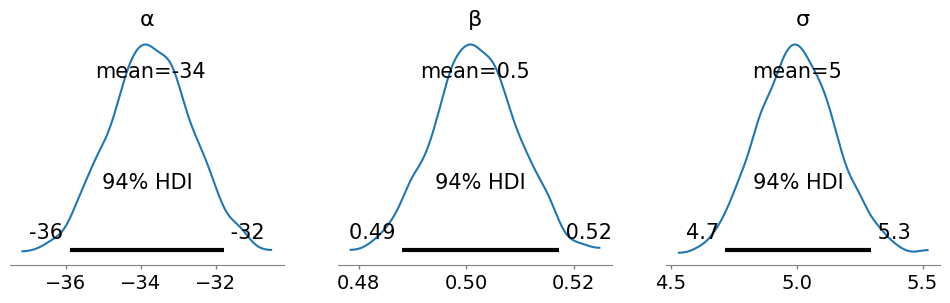

In [ ]:
az.plot_posterior(idata_hw, var_names=["~μ"], figsize=(12, 3))

Text(0, 0.5, 'weight')

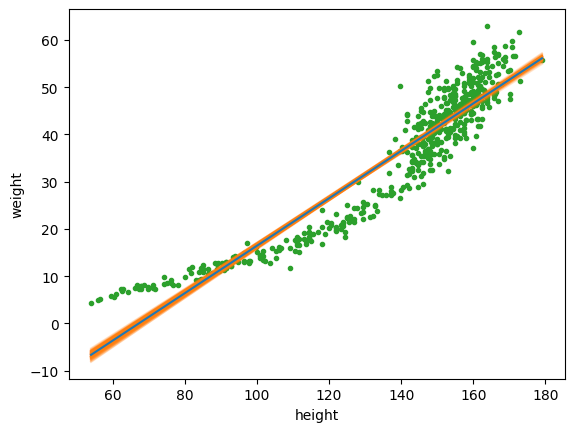

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_hw, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(howell.height.min(), howell.height.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("height")
ax.set_ylabel("weight")

Shockingly, as the data doesn't look like a straight line, straight lines don't predict it all that well.

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [ ]:
pm.sample_posterior_predictive(idata_hw, model=model_hw,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

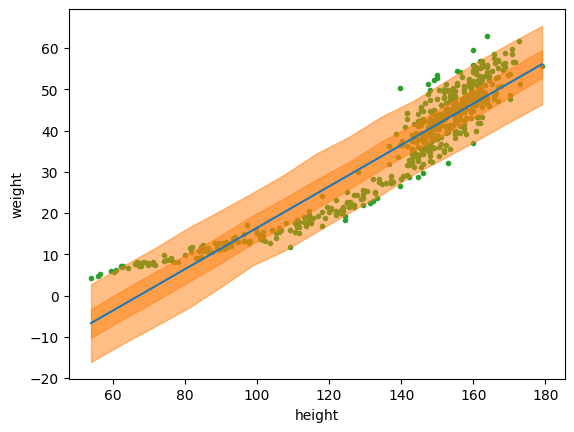

In [ ]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_hw.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
heights = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(heights)
x = np.linspace(heights.min(), heights.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_hw.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(heights[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("height")
ax.set_ylabel("weight")

This model seems to fit pretty well. We can't draw a horizontal line all the way across through the orange zone, indicating a linear trend, and on a purely visual level the data stays decently close to the blue line mean. The fit isn't perfect though, it definitely looks like another curve might fit better, as for very low heights, the line underpredicts weight and for medium heights it overpredicts them. Additionally, the model doesn't totally exclude the possibility of negative weights, which is obviously a problem.

<Axes: xlabel='y_pred'>

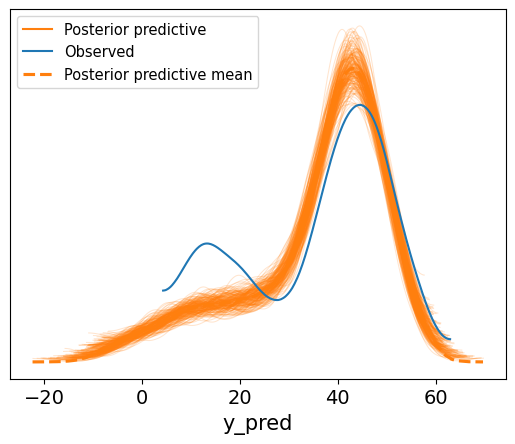

In [ ]:
az.plot_ppc(idata_hw, num_pp_samples=200, colors=["C1", "C0", "C1"])

This fits what we thought. It's kinda ok, but not great, especially in the beginning (plus negative values bad).

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [ ]:
with pm.Model() as model_qu: #Imma make the mean qu instead of linear because qualitatively that looks like it would fit better (plus it eliminates the negative values problem)
    #priors for the linear part of our model
    α = pm.HalfNormal("α", sigma=10) #this is half normal because I wan't the quadratic to open up
    β = pm.HalfNormal("β", sigma=100) #also positive only because I want to eliminate the possibility of negative weight. Centered at 0 because 0 height = 0 weight seems reasonable to me.

    #the variance in weight seems to increase as height does, so lets incorporate that too
    #priors for the line for our standard deviation
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)


    #this is the quadratic part of our model
    μ = pm.Deterministic("μ", α * howell.height * howell.height + β)

    #standard deviation line; this allows our variance to vary over the x values
    σ = pm.Deterministic("σ", γ + δ * howell.height)


    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    #inference data object
    idata_qu = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


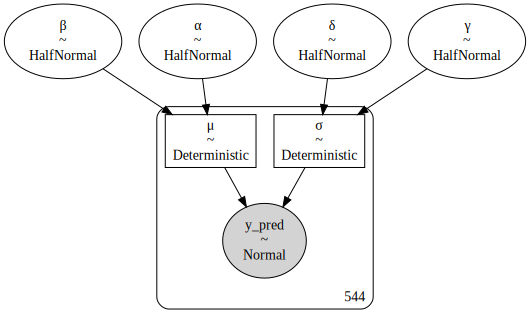

In [ ]:
pm.model_to_graphviz(model_qu)

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (548) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
        <Axes: title={'center': 'γ'}>, <Axes: title={'center': 'δ'}>],
       [<Axes: title={'center': 'σ\n0'}>,
        <Axes: title={'center': 'σ\n1'}>,
        <Axes: title={'center': 'σ\n2'}>,
        <Axes: title={'center': 'σ\n3'}>],
       [<Axes: title={'center': 'σ\n4'}>,
        <Axes: title={'center': 'σ\n5'}>,
        <Axes: title={'center': 'σ\n6'}>,
        <Axes: title={'center': 'σ\n7'}>],
       [<Axes: title={'center': 'σ\n8'}>,
        <Axes: title={'center': 'σ\n9'}>,
        <Axes: title={'center': 'σ\n10'}>,
        <Axes: title={'center': 'σ\n11'}>],
       [<Axes: title={'center': 'σ\n12'}>,
        <Axes: title={'center': 'σ\n13'}>,
        <Axes: title={'center': 'σ\n14'}>,
        <Axes: title={'center': 'σ\n15'}>],
       [<Axes: title={'center': 'σ\n16'}>,
        <Axes: title={'center': 'σ\n17'}>,
        <Axes: title={'center': 'σ\n18'}>,
        <Axes: title={'center': 'σ\n19'}>],
    

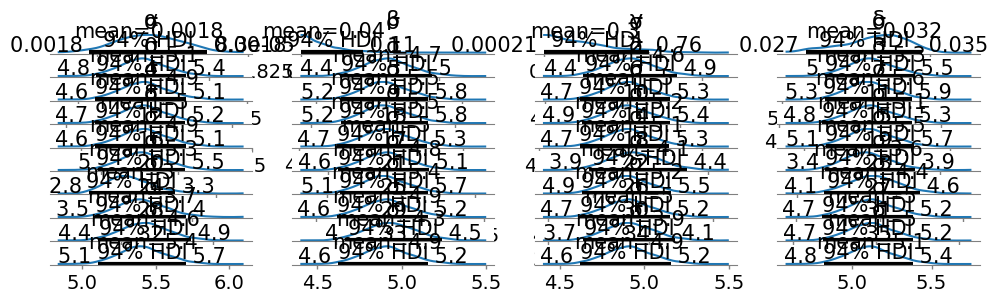

In [ ]:
az.plot_posterior(idata_qu, var_names=["~μ"], figsize=(12, 3))

oh this doesn't really work for this kind of model.

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

In [ ]:
#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_qu, model = model_qu, extend_inferencedata=True
    )


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

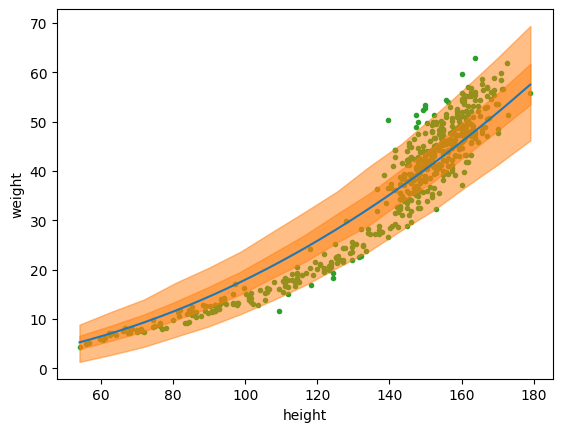

In [ ]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_qu.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
heights = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(heights)
x = np.linspace(heights.min(), heights.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_qu.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(heights[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("height")
ax.set_ylabel("weight")

<Axes: xlabel='y_pred'>

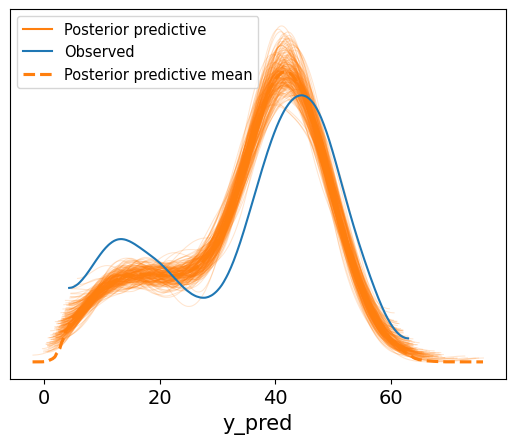

In [ ]:
az.plot_ppc(idata_qu, num_pp_samples=200, colors=["C1", "C0", "C1"])


This is pretty good, there are no more negative weights predicted, and the behavior consistently fits "kinda ok" for the whole time.It's a bit frustrating that the posterior predictive is predictably offset from the data. It looks as though just shifting the orange to the right slightly would fix most of the problems with the fit, so I'm not sure why the model was unable to do that. In any case, I think the overall shape of the posterior is similar in a way that makes this model helpful.